# A simple dust screen with varying greyness

Let us now investigate the effect of changing the dust law. The simplest way to test this for optical emission lines is changing $R_V$.

In [1]:
# Import main libraries
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
from astropy.table import Table

# Some useful functions for calculations/plots
from natastro import utils
import natastro.plotutils as nplot
from natastro.labels import get_labels

In [2]:
# ===> Set up plots
columnwidth = 240.
textwidth = 504.
screenwidth = 1024.

ps = 'times'
if (ps == 'times'):
    psetup = nplot.plotSetup
    
labels = get_labels(ps)

---
## 1. Reading the data

In [3]:
# Local dir
table_file = 'example_data/SIGNALS_table_spaxels_8247-12704.hdf5'

# Read spaxels table
ts = Table.read(table_file, path='/spaxel')

# Read integrated table (one single row, because we are dealing with a single galaxy)
ti = Table.read(table_file, path='/integrated')

In [4]:
# Emission line quantities start with El_. El_F_6563 = Ha flux; El_eF_6563 = uncertainty Ha flux; etc.
ti

plateid,ifudsgn,mangaid,ra,dec,x0,y0,redshift,pixel_scale_pc,lumDistance_Mpc,x,y,SN,D4000,Lobn,Mcor,Mini,at_flux,at_mass,alogZ_flux,alogZ_mass,tau_V,v_0,v_d,x_Y,flux_unit,El_F_3726,El_EW_3726,El_v0_3726,El_vd_3726,El_vdins_3726,El_lcrms_3726,El_flag_3726,El_F_3729,El_EW_3729,El_v0_3729,El_vd_3729,El_vdins_3729,El_lcrms_3729,El_flag_3729,El_F_4340,El_EW_4340,El_v0_4340,El_vd_4340,El_vdins_4340,El_lcrms_4340,El_flag_4340,El_F_4861,El_EW_4861,El_v0_4861,El_vd_4861,El_vdins_4861,El_lcrms_4861,El_flag_4861,El_F_5007,El_EW_5007,El_v0_5007,El_vd_5007,El_vdins_5007,El_lcrms_5007,El_flag_5007,El_F_6563,El_EW_6563,El_v0_6563,El_vd_6563,El_vdins_6563,El_lcrms_6563,El_flag_6563,El_F_6584,El_EW_6584,El_v0_6584,El_vd_6584,El_vdins_6584,El_lcrms_6584,El_flag_6584,El_F_6716,El_EW_6716,El_v0_6716,El_vd_6716,El_vdins_6716,El_lcrms_6716,El_flag_6716,El_F_6731,El_EW_6731,El_v0_6731,El_vd_6731,El_vdins_6731,El_lcrms_6731,El_flag_6731,El_A_4861,El_AN_4861,El_eF_4861,El_SN_4861,El_A_6563,El_AN_6563,El_eF_6563,El_SN_6563,El_A_3726,El_AN_3726,El_eF_3726,El_SN_3726,El_A_3729,El_AN_3729,El_eF_3729,El_SN_3729,El_A_4340,El_AN_4340,El_eF_4340,El_SN_4340,El_A_5007,El_AN_5007,El_eF_5007,El_SN_5007,El_A_6584,El_AN_6584,El_eF_6584,El_SN_6584,El_A_6716,El_AN_6716,El_eF_6716,El_SN_6716,El_A_6731,El_AN_6731,El_eF_6731,El_SN_6731
int16,int64,bytes9,float64,float64,float32,float32,float32,float32,float32,int16,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
8247,12704,1-137870,136.730098431,44.121516356,18.254055,18.251282,0.0494434,967.25146,219.7264,0,0,12.687684779725029,1.1883676993883459,2379950.0,30941800000.0,55273900000.0,9.095517494117287,9.723635921467427,-0.41088757093992734,-0.5228395800222724,0.1305105230709025,-7.05,77.47,0.07321176103609899,1e-17,743.8332824060375,6.174984018637815,-23.351965645090623,86.41152706623457,86.79411419187491,4.7326837208492325,0,1178.3535248336489,9.74321336816868,-23.351965645090623,86.41152706623457,86.72077671478495,4.7326837208492325,0,378.7611653842843,2.432137887459518,-15.731413715812474,68.51652871540531,77.39375542713617,2.2681950447466015,0,884.4457743871696,5.1548319508780835,-15.731413715812474,68.51652871540531,73.81146871734697,2.2699216531806314,0,496.46166829843014,3.0503682309994646,-16.815366574499784,87.60736973423657,73.13020610719049,1.9964394868207227,0,3421.612793763468,24.954903910057254,-15.731413715812474,68.51652871540531,71.19144060156988,4.487691242975497,0,1105.4684965837976,8.092999413095596,-15.308893819711843,70.65735961816044,71.11109595591358,4.487691242975497,0,706.5657209915797,5.300086613740803,-13.849576837700905,71.32642575608486,70.6104553649397,1.8675898220046057,0,502.56010244004744,3.7808487344140866,-13.849576837700905,71.32642575608486,70.55981257659631,1.8675898220046057,0,216.05842271176945,95.18320705431694,7.105449068882154,124.47429653117094,631.0813960468668,140.62495877689605,16.166885754003896,211.6432840453561,194.94482132740762,41.19117879536365,14.302767935255908,52.00624702666887,308.724958476101,65.23253542510197,14.305072802400607,82.37312323471038,100.96872365095737,44.51500936165629,6.796735107890691,55.7269276162551,103.919180165038

---
## 2. Choosing dust laws

In [5]:
# Load a script with a variety of dust laws
from natastro.pycasso2.reddening import calc_redlaw

# Note: This is originally from pycasso2.redenning,
# which can be downloaded at https://bitbucket.org/streeto/pycasso2
# If you have pycasso2 installed, simply use it as
#    from pycasso2.reddening import calc_redlaw

Let us compare the Cardelli, Clayton & Mathis (1989) extinction law with $R_V = 2.0$, $3.1$ and $5.0$.

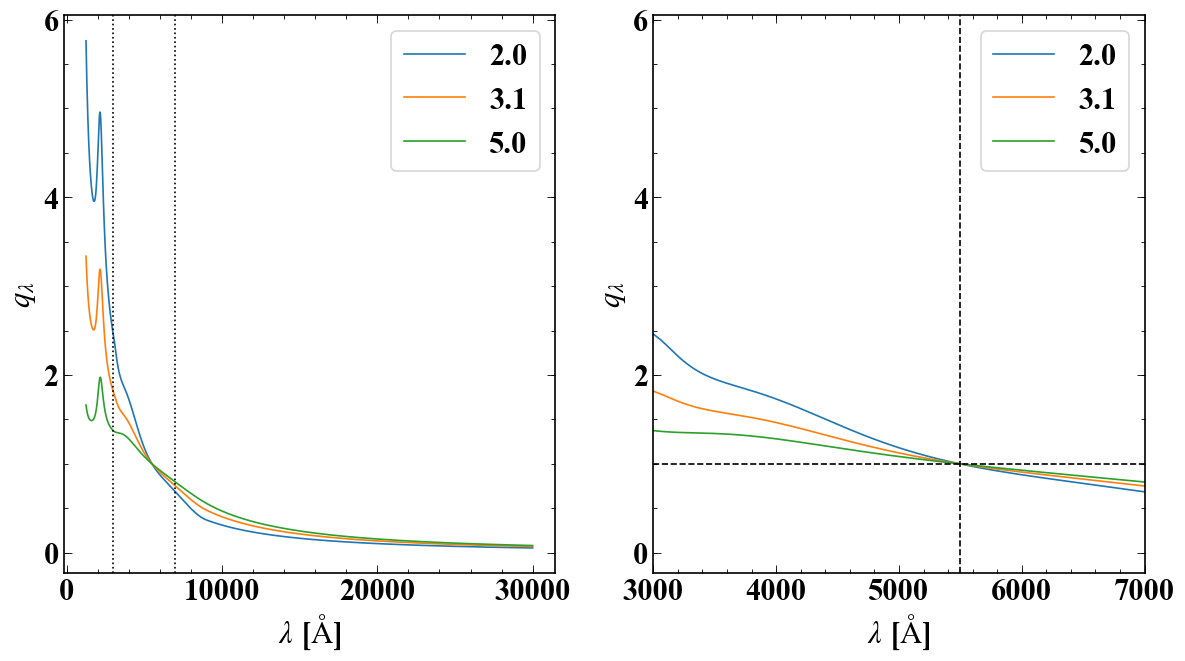

In [6]:
# Define lambdas
ll = np.linspace(1250, 30e3, 1000)

q_20 = calc_redlaw(ll, 'CCM', R_V=2.0)
q_31 = calc_redlaw(ll, 'CCM', R_V=3.1)
q_50 = calc_redlaw(ll, 'CCM', R_V=5.0)

# Plot
psetup(fig_width_pt=2*textwidth, aspect=0.5, fontsize=22) 
plt.figure()
plt.clf()

gs = gridspec.GridSpec(1, 2)

ax = plt.subplot(gs[0, 0])
plt.plot(ll, q_20, label='2.0')
plt.plot(ll, q_31, label='3.1')
plt.plot(ll, q_50, label='5.0')
plt.legend()

ax.set_xlabel(r'$\lambda$ [$\mathrm{\AA}$]')
ax.set_ylabel(r'$q_\lambda$')
nplot.fix_ticks(ax, ny=5)

ax.axvline(3000, ls=':', c='k')
ax.axvline(7000, ls=':', c='k')

# Zooming into the optical
ax = plt.subplot(gs[0, 1])
plt.plot(ll, q_20, label='2.0')
plt.plot(ll, q_31, label='3.1')
plt.plot(ll, q_50, label='5.0')
plt.legend()
plt.xlim(3000, 7000)

ax.set_xlabel(r'$\lambda$ [$\mathrm{\AA}$]')
ax.set_ylabel(r'$q_\lambda$')
nplot.fix_ticks(ax, ny=5)

ax.axhline(1, ls='--', c='k')
ax.axvline(5500, ls='--', c='k')

---
## 3. Calculating the optical depth

From the last notebook, remember that
\tau_V &= \frac{1}{q_\mathrm{H\beta} - q_\mathrm{H\alpha}} \; 
          \ln \frac{F_\mathrm{H\alpha} / F_\mathrm{H\beta}}{F_{\mathrm{H\alpha},0}/F_{\mathrm{H\beta },0}}.
\end{align}
This meas $\tau_V$ depends on the dust law we have chosen. Let us see how it varies according to $R_V$.

In [7]:
B = 2.87
HaHb = ts['El_F_6563'] / ts['El_F_4861']
ts['HaHb'] = HaHb

RVs = [2.0, 3.1, 5.0]
tauVs = []

for RV in RVs:
    qHb, qHa = calc_redlaw([4861, 6563], 'CCM', R_V=RV)
    tauV = (qHb - qHa)**-1 * np.log(HaHb / B)
    tauVs.append(tauV)

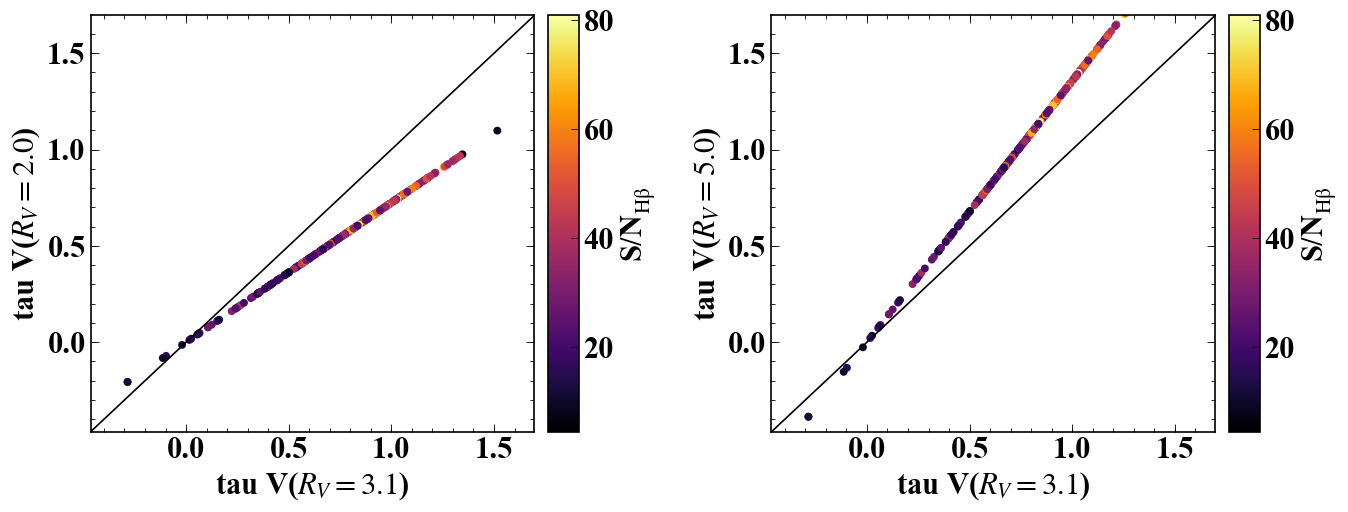

In [8]:
# Comparing our tau_Vs
psetup(fig_width_pt=2*textwidth, aspect=0.4, fontsize=22) 
plt.figure()
plt.clf()

gs = gridspec.GridSpec(1, 2)

# 3.1 vs 2.0
ax = plt.subplot(gs[0, 0])
im = ax.scatter(tauVs[1], tauVs[0], s=20, c=ts['El_SN_4861'], cmap='inferno')

ax.set_xlabel(nplot.label('tau_V', labels) + '($R_V = 3.1$)')
ax.set_ylabel(nplot.label('tau_V', labels) + '($R_V = 2.0$)')
nplot.fix_ticks(ax, ny=5, nx=5)
nplot.plot_identity(tauVs[1], tauVs[0])

# Add colourbar
cb = nplot.tight_colorbar(im)
cb.set_label(nplot.label('El_SN_4861', labels))



# 3.1 vs 5.0
ax = plt.subplot(gs[0, 1])
im = ax.scatter(tauVs[1], tauVs[2], s=20, c=ts['El_SN_4861'], cmap='inferno')

ax.set_xlabel(nplot.label('tau_V', labels) + '($R_V = 3.1$)')
ax.set_ylabel(nplot.label('tau_V', labels) + '($R_V = 5.0$)')
nplot.fix_ticks(ax, ny=5, nx=5)
nplot.plot_identity(tauVs[1], tauVs[0])

# Add colourbar
cb = nplot.tight_colorbar(im)
cb.set_label(nplot.label('El_SN_4861', labels))


plt.tight_layout()

---
## 4. The effect of changing $R_V$ to dereddened emission lines

Remember that:
\begin{align}
F_{\lambda,0} = F_{\lambda} \; e^{+\tau_\lambda}.
\end{align}

In [9]:
def deredden_line_RV(ll, tauV, RV):
    q_l = calc_redlaw([ll], 'CCM', R_V=RV)[0]
    tau_l = tauV * q_l
    ts[f'El_F_{ll}_RV{RV}_dr'] = ts[f'El_F_{ll}'] * np.exp(tau_l)
    
    
for RV, tauV in zip(RVs, tauVs):
    for ll in [3726, 3729, 4861, 5007, 6563, 6584]:
        deredden_line_RV(ll, tauV, RV)
        
# Get info for 3727
ts['El_F_3727'] = utils.safe_sum( ts['El_F_3726'], ts['El_F_3729'] )
for RV in RVs:
    ts[f'El_F_3727_RV{RV}_dr'] = utils.safe_sum( ts[f'El_F_3726_RV{RV}_dr'], ts[f'El_F_3729_RV{RV}_dr'] )

In [10]:
# Common line ratios
ts['log_O3Hb'] = utils.safe_log10( utils.safe_div(ts['El_F_5007'], ts['El_F_4861']) )
ts['log_N2Ha'] = utils.safe_log10( utils.safe_div(ts['El_F_6584'], ts['El_F_6563']) )
ts['O23'] = utils.safe_log10( utils.safe_div( utils.safe_sum(ts['El_F_5007'] * 1.34, ts['El_F_3727']), ts['El_F_4861'] ) )
ts['O3O2'] = utils.safe_log10( utils.safe_div( ts['El_F_5007'] * 1.34, ts['El_F_3727']) )
ts['log_O3N2'] = utils.safe_sub( ts['log_O3Hb'], ts['log_N2Ha'] )

for RV in RVs:
    ts[f'log_O3Hb_RV{RV}_dr'] = utils.safe_log10( utils.safe_div(ts[f'El_F_5007_RV{RV}_dr'], ts[f'El_F_4861_RV{RV}_dr']) )
    ts[f'log_N2Ha_RV{RV}_dr'] = utils.safe_log10( utils.safe_div(ts[f'El_F_6584_RV{RV}_dr'], ts[f'El_F_6563_RV{RV}_dr']) )
    ts[f'O23_RV{RV}_dr'] = utils.safe_log10( utils.safe_div( utils.safe_sum(ts[f'El_F_5007_RV{RV}_dr'] * 1.34, ts[f'El_F_3727_RV{RV}_dr']), ts[f'El_F_4861_RV{RV}_dr'] ) )
    ts[f'O3O2_RV{RV}_dr'] = utils.safe_log10( utils.safe_div( ts[f'El_F_5007_RV{RV}_dr'] * 1.34, ts[f'El_F_3727_RV{RV}_dr']) )

## 6. Checking the effect of $R_V$ on emission line ratios

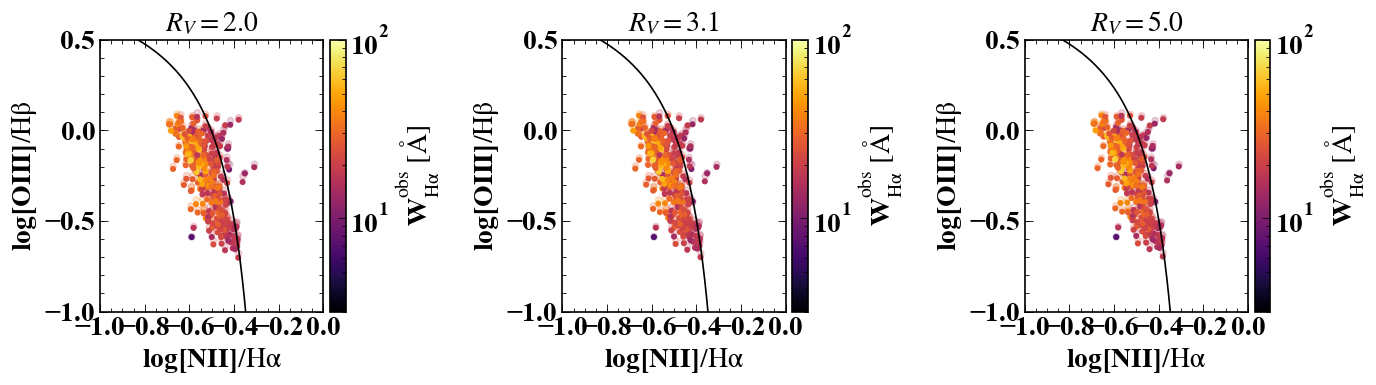

In [11]:
# Classical BPT
import matplotlib.colors as colors

# Defining BPT lines
Kewl_O3Hb = lambda N2Ha: np.where( (N2Ha > -999) & (N2Ha <  0.47), 1.19 + 0.61 / (N2Ha - 0.47) , -999.)
Kauf_O3Hb = lambda N2Ha: np.where( (N2Ha > -999) & (N2Ha <  0.05), 1.30 + 0.61 / (N2Ha - 0.05) , -999.)
Graz_O3Hb = lambda N2Ha: np.where( (N2Ha > -999) & (N2Ha < -0.20), 0.96 + 0.29 / (N2Ha + 0.20) , -999.)

psetup(fig_width_pt=screenwidth, aspect=0.3, fontsize=20) 
plt.figure()
plt.clf()

gs = gridspec.GridSpec(1, 3)

for i, RV in enumerate(RVs):
    ax = plt.subplot(gs[0, i])
    # Original 
    im = ax.scatter(ts['log_N2Ha'], ts['log_O3Hb'], s=20, c=ts['El_EW_6563'], alpha=0.2, cmap='inferno', vmin=3, vmax=100, norm=colors.LogNorm())
    # Dereddened 
    im = ax.scatter(ts[f'log_N2Ha_RV{RV}_dr'], ts[f'log_O3Hb_RV{RV}_dr'], s=10, c=ts['El_EW_6563'], cmap='inferno', vmin=3, vmax=100, norm=colors.LogNorm())
    ax.set_xlabel(nplot.label('log_N2Ha', labels))
    ax.set_ylabel(nplot.label('log_O3Hb', labels))

    # Plot S06 line
    x = np.linspace(-2, -0.3, 1000)
    plt.plot(x, Graz_O3Hb(x), 'k')
    plt.xlim(-1, 0.)
    plt.ylim(-1, 0.5)
    nplot.fix_ticks(ax, ny=5)

    # Add colourbar
    cb = nplot.tight_colorbar(im)
    cb.set_label(nplot.label('El_EW_6563', labels))
    
    ax.set_title(f'$R_V = {RV}$')
    
plt.tight_layout()

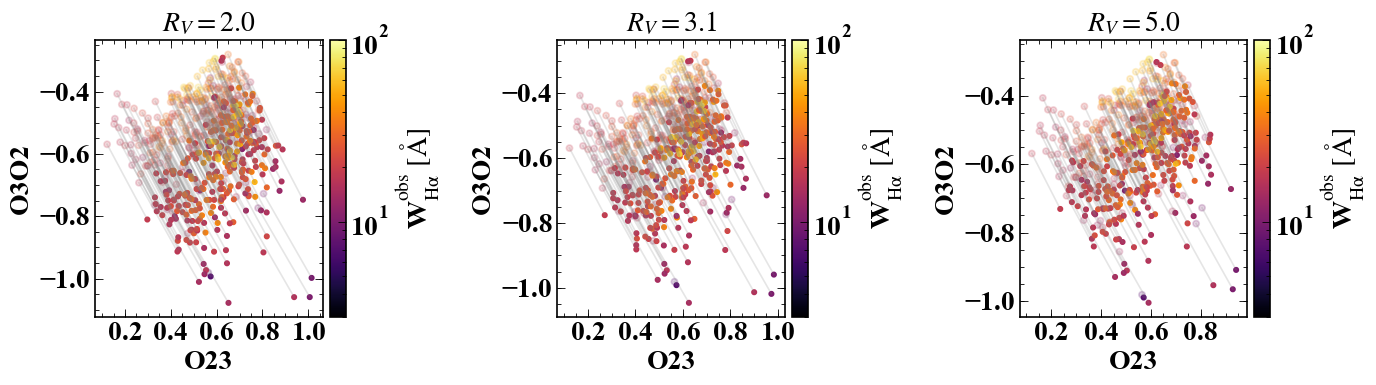

In [12]:
# MacGaugh 1991 plot: O23 vs O3O2
import matplotlib.colors as colors

psetup(fig_width_pt=screenwidth, aspect=0.3, fontsize=20) 
plt.figure()
plt.clf()

gs = gridspec.GridSpec(1, 3)

for i, RV in enumerate(RVs):
    ax = plt.subplot(gs[0, i])
    # Original 
    im = ax.scatter(ts['O23'], ts['O3O2'], s=20, c=ts['El_EW_6563'], alpha=0.2, cmap='inferno', vmin=3, vmax=100, norm=colors.LogNorm())
    # Dereddened 
    im = ax.scatter(ts[f'O23_RV{RV}_dr'], ts[f'O3O2_RV{RV}_dr'], s=10, c=ts['El_EW_6563'], cmap='inferno', vmin=3, vmax=100, norm=colors.LogNorm())
    ax.set_xlabel(nplot.label('O23', labels))
    ax.set_ylabel(nplot.label('O3O2', labels))
    nplot.fix_ticks(ax, ny=5)
    
    # Connect points
    for x1, y1, x2, y2 in zip(ts['O23'], ts['O3O2'], ts[f'O23_RV{RV}_dr'], ts[f'O3O2_RV{RV}_dr']):
        plt.plot((x1, x2), (y1, y2), 'grey', alpha=0.2)

    # Add colourbar
    cb = nplot.tight_colorbar(im)
    cb.set_label(nplot.label('El_EW_6563', labels))
    
    ax.set_title(f'$R_V = {RV}$')
    
plt.tight_layout()

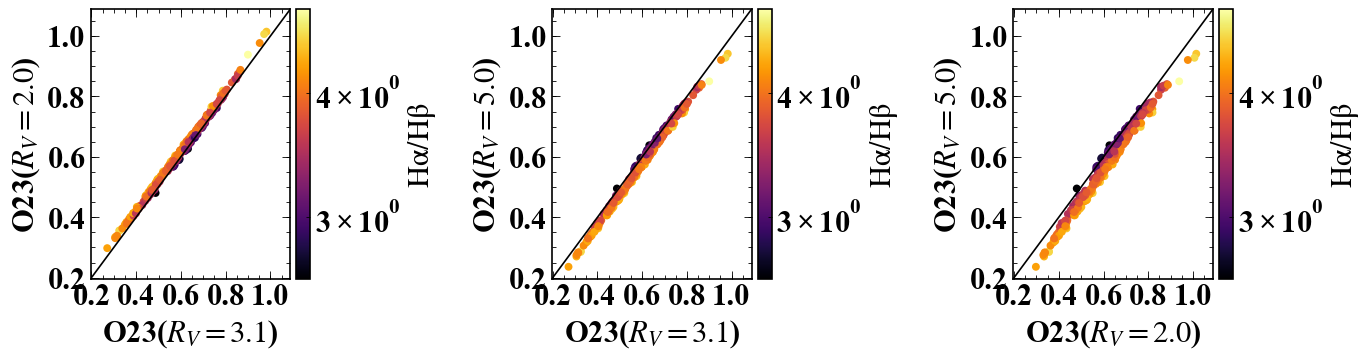

In [13]:
# MacGaugh 1991 plot: O23 vs O3O2
import matplotlib.colors as colors

psetup(fig_width_pt=screenwidth, aspect=0.5, fontsize=22) 
plt.figure()
plt.clf()

gs = gridspec.GridSpec(2, 3)

ax = plt.subplot(gs[0, 0])
im = ax.scatter(ts[f'O23_RV3.1_dr'], ts[f'O23_RV2.0_dr'], s=20, c=ts['HaHb'], cmap='inferno', norm=colors.LogNorm())
nplot.plot_identity(ts[f'O23_RV3.1_dr'], ts[f'O23_RV2.0_dr'])
nplot.fix_ticks(ax, ny=5)

ax.set_xlabel(nplot.label('O23', labels) + '($R_V = 3.1$)')
ax.set_ylabel(nplot.label('O23', labels) + '($R_V = 2.0$)')

# Add colourbar
cb = nplot.tight_colorbar(im)
cb.set_label(nplot.label('HaHb', labels))


ax = plt.subplot(gs[0, 1])
im = ax.scatter(ts[f'O23_RV3.1_dr'], ts[f'O23_RV5.0_dr'], s=20, c=ts['HaHb'], cmap='inferno', norm=colors.LogNorm())
nplot.plot_identity(ts[f'O23_RV3.1_dr'], ts[f'O23_RV2.0_dr'])
nplot.fix_ticks(ax, ny=5)

ax.set_xlabel(nplot.label('O23', labels) + '($R_V = 3.1$)')
ax.set_ylabel(nplot.label('O23', labels) + '($R_V = 5.0$)')

# Add colourbar
cb = nplot.tight_colorbar(im)
cb.set_label(nplot.label('HaHb', labels))



ax = plt.subplot(gs[0, 2])
im = ax.scatter(ts[f'O23_RV2.0_dr'], ts[f'O23_RV5.0_dr'], s=20, c=ts['HaHb'], cmap='inferno', norm=colors.LogNorm())
nplot.plot_identity(ts[f'O23_RV3.1_dr'], ts[f'O23_RV2.0_dr'])
nplot.fix_ticks(ax, ny=5)

ax.set_xlabel(nplot.label('O23', labels) + '($R_V = 2.0$)')
ax.set_ylabel(nplot.label('O23', labels) + '($R_V = 5.0$)')

# Add colourbar
cb = nplot.tight_colorbar(im)
cb.set_label(nplot.label('HaHb', labels))

    
plt.tight_layout()

In [14]:
import scipy.interpolate

# Curti et al. (2017), Table 2 - Note that what they call `R23' I call O23
O23_coef  = [  0.527 , -1.569 , -1.652 , -0.421 ,  0.    ]

## Reverse equations
x = np.linspace(8.4, 8.85, 1000) - 8.69
O23 = np.polyval(O23_coef[::-1], x)
interp_O23 = scipy.interpolate.interp1d(O23, x, kind = 'linear', bounds_error = False)
Zneb_O23 = lambda O23: interp_O23(O23) + 8.69

In [15]:
# Change of 0.1 dex in O23 corresponds to what change in O/H?
    
print(Zneb_O23(0.6), Zneb_O23(0.7))

8.640974517239218 8.563410302483287
